<a href="https://colab.research.google.com/github/joefreire/previsao/blob/main/Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [394]:
from google.colab import files, drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot


 
df = pd.read_csv('/content/drive/MyDrive/previsao/dataset2.csv')
df["Escopo1"]=df["Escopo1"].str.replace(",",".").astype(float)
df["Escopo2"]=df["Escopo2"].str.replace(",",".").astype(float)
df["Escopo3"]=df["Escopo3"].str.replace(",",".").astype(float)
df['Ref']=pd.to_datetime(df['Ref'])
df.set_index('Ref',inplace=True)

escopo1 = df.filter(['Ref','Escopo1'], axis=1)


escopo1.head()


,Escopo1
Ref,
2016-01-01,56.077615
2016-02-01,44.377551
2016-03-01,30.970758
2016-04-01,13.966298
2016-05-01,4.044635


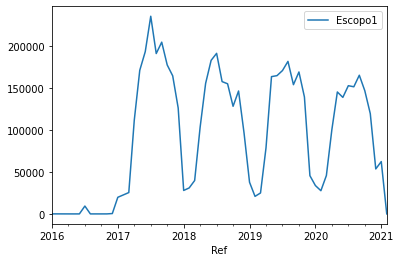

In [395]:
escopo1.plot()

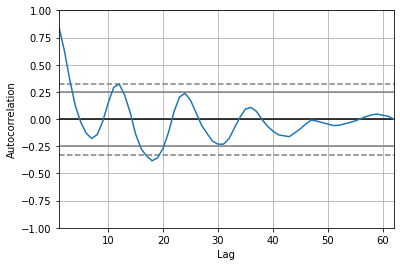

In [396]:
autocorrelation_plot(escopo1)
pyplot.show()

In [397]:
### Teste da amostra
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(escopo1['Escopo1'])
#Ho: amostra não estacionaria
#H1: amostra estacionaria

def adfuller_test(amostra):
    result=adfuller(amostra)
    labels = ['ADF Test Statistic','p-value','#Lags Used','observações']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários")
    else:
        print("evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária ")


adfuller_test(escopo1['Escopo1'])

ADF Test Statistic : -2.377818956596378
p-value : 0.14809495276588175
#Lags Used : 8
observações : 53
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


In [398]:
escopo1['Primeira Diferenciação'] = escopo1['Escopo1'] - escopo1['Escopo1'].shift(1)
escopo1['Escopo1'].shift(1)

Ref
2016-01-01              NaN
2016-02-01        56.077615
2016-03-01        44.377551
2016-04-01        30.970758
2016-05-01        13.966298
2016-06-01         4.044635
2016-07-01        20.078825
2016-08-01      9368.828837
2016-09-01        16.267830
2016-10-01        17.860978
2016-11-01        16.632220
2016-12-01        26.636900
2017-01-01       432.960722
2017-02-01     19820.429220
2017-03-01     22621.057850
2017-04-01     25464.145880
2017-05-01    111728.580700
2017-06-01    171170.897500
2017-07-01    193387.310000
2017-08-01    235597.318200
2017-09-01    191134.236800
2017-10-01    204710.180100
2017-11-01    177540.894200
2017-12-01    164588.791400
2018-01-01    126234.946700
2018-02-01     27964.058010
2018-03-01     30962.138810
2018-04-01     39797.775150
2018-05-01    103458.495500
2018-06-01    155602.192900
2018-07-01    183013.429400
2018-08-01    191377.960800
2018-09-01    157699.710000
2018-10-01    155108.014900
2018-11-01    128268.617900
2018-12-01    14

In [399]:
escopo1['Diferença Sazonal']=escopo1['Escopo1']-escopo1['Escopo1'].shift(12)
escopo1.head(14)

,Escopo1,Primeira Diferenciação,Diferença Sazonal
Ref,,,
2016-01-01,56.077615,NaN,NaN
2016-02-01,44.377551,-11.700064,NaN
2016-03-01,30.970758,-13.406793,NaN
2016-04-01,13.966298,-17.004460,NaN
2016-05-01,4.044635,-9.921663,NaN
2016-06-01,20.078825,16.034190,NaN
2016-07-01,9368.828837,9348.750012,NaN
2016-08-01,16.267830,-9352.561007,NaN
2016-09-01,17.860978,1.593148,NaN


In [400]:
## dickey fuller test
adfuller_test(escopo1['Diferença Sazonal'].dropna())

ADF Test Statistic : -8.135187845574203
p-value : 1.063901248181605e-12
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


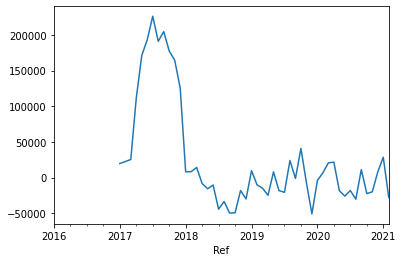

In [401]:
escopo1['Diferença Sazonal'].plot()

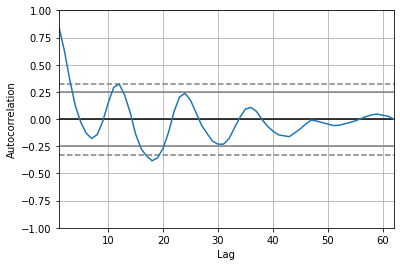

In [402]:
autocorrelation_plot(escopo1['Escopo1'])
plt.show()

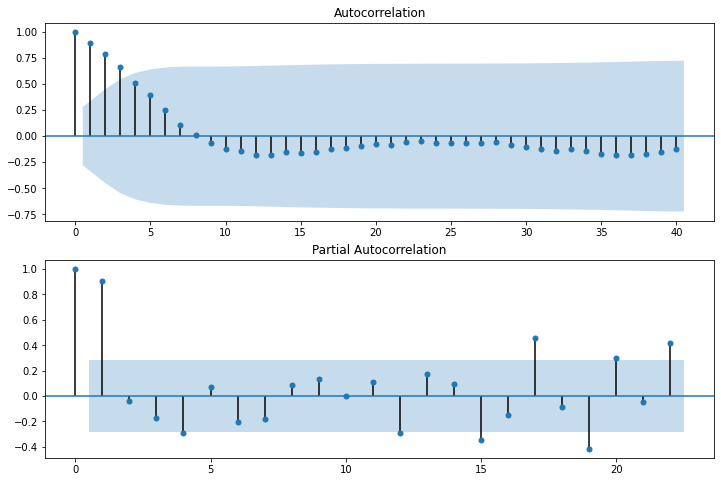

In [403]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo1['Diferença Sazonal'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo1['Diferença Sazonal'].iloc[13:],lags=22,ax=ax2)

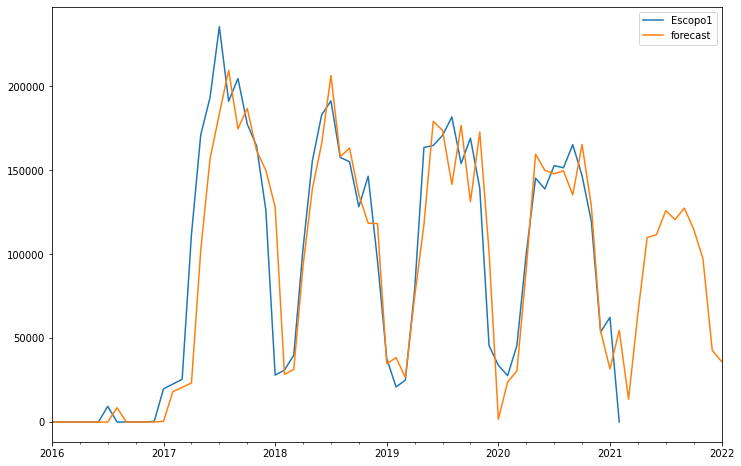

In [511]:

from pandas.tseries.offsets import DateOffset
model=sm.tsa.statespace.SARIMAX(escopo1['Escopo1'],order=(1,0,0),seasonal_order=(1,1,1,12))
results=model.fit()
future_dates=[escopo1.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=escopo1.columns)
future_df=pd.concat([escopo1,future_datest_df])

future_df['forecast'] = results.predict(end = 72)  

future_df[['Escopo1', 'forecast']].plot(figsize=(12, 8))


In [489]:
future_df.tail(12)

,Escopo1,Primeira Diferenciação,Diferença Sazonal,forecast
2021-02-01,28.425261,-62368.529369,-27634.122019,54657.301726
2021-03-01,NaN,NaN,NaN,13621.024837
2021-04-01,NaN,NaN,NaN,64517.841587
2021-05-01,NaN,NaN,NaN,109935.785110
2021-06-01,NaN,NaN,NaN,111644.548974
2021-07-01,NaN,NaN,NaN,125967.891502
2021-08-01,NaN,NaN,NaN,120678.702653
2021-09-01,NaN,NaN,NaN,127462.111780
2021-10-01,NaN,NaN,NaN,114944.259856
2021-11-01,NaN,NaN,NaN,97359.028272


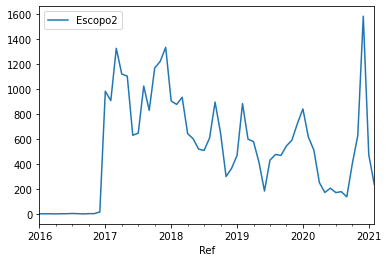

In [458]:
#dados escopo2
escopo2 = df.filter(['Ref','Escopo2'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano

for index, row in escopo2.iterrows():
    if row['Escopo2'] <= 0:
      mediaMes = escopo2['Escopo2'].groupby([escopo2.index.month]).mean()[index.month]
      mediasAno = escopo2['Escopo2'].groupby([escopo2.index.year]).mean()
      mediaAno = escopo2['Escopo2'].groupby([escopo2.index.year]).mean()[index.year]

      if mediaMes == 0.0:         
         row['Escopo2'] = mediaAno
      elif mediaAno == 0.0:  
         if (index.year-1 in mediasAno) and ((mediaMes * 1.2 < mediasAno[index.year-1]) or (mediaMes * 1.2 > mediasAno[index.year-1])):
          row['Escopo2'] = mediasAno[index.year-1]
         else:
          row['Escopo2'] = mediaMes
      elif (mediaAno < (mediaMes * 1.2)):
         row['Escopo2'] = mediaAno
      else:
         row['Escopo2'] = mediaMes        
escopo2.plot()


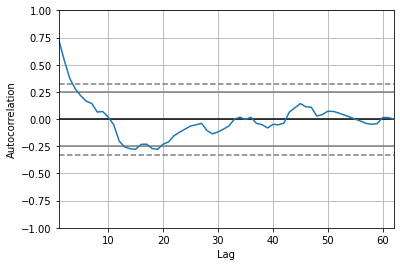

In [412]:
autocorrelation_plot(escopo2)
pyplot.show()


In [464]:
adfuller_test(escopo2['Escopo2'])

ADF Test Statistic : -3.1150144121051886
p-value : 0.025461824303790195
#Lags Used : 0
observações : 61
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


In [465]:
escopo2['Primeira Diferenciação'] = escopo2['Escopo2'] - escopo2['Escopo2'].shift(1)
escopo2['Diferença Sazonal']=escopo2['Escopo2']-escopo2['Escopo2'].shift(12)
print(escopo2)

                Escopo2  Primeira Diferenciação  Diferença Sazonal
Ref                                                               
2016-01-01     1.945514                     NaN                NaN
2016-02-01     2.107640                0.162126                NaN
2016-03-01     2.283277                0.175637                NaN
2016-04-01     1.226124               -1.057153                NaN
2016-05-01     2.473550                1.247426                NaN
2016-06-01     2.679679                0.206129                NaN
2016-07-01     4.583390                1.903711                NaN
2016-08-01     2.902986               -1.680404                NaN
2016-09-01     1.018876               -1.884110                NaN
2016-10-01     3.144901                2.126025                NaN
2016-11-01     3.406977                0.262075                NaN
2016-12-01    16.517780               13.110803                NaN
2017-01-01   981.313876              964.796096         979.36

In [466]:
## dickey fuller test
adfuller_test(escopo2['Diferença Sazonal'].dropna())


ADF Test Statistic : -6.090660237157593
p-value : 1.0384075926380125e-07
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


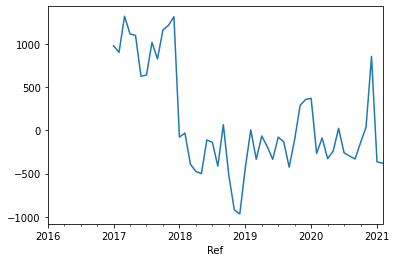

In [467]:
escopo2['Diferença Sazonal'].plot()

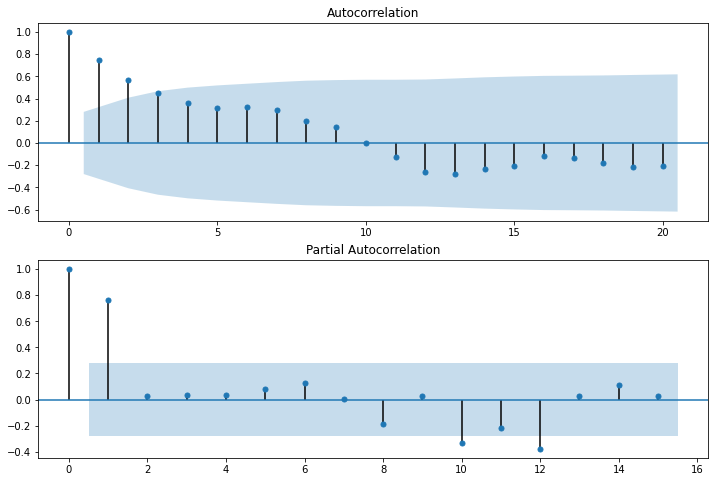

In [468]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo2['Diferença Sazonal'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo2['Diferença Sazonal'].iloc[13:],lags=15,ax=ax2)

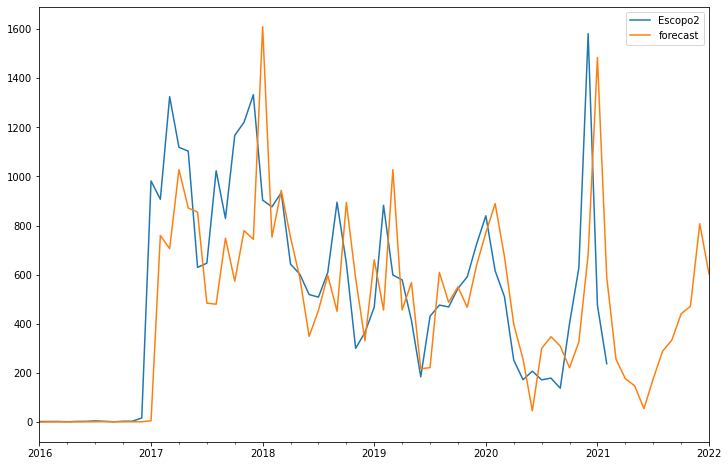

In [510]:
#essa é o modelo que foi aprendido para as previsões
model2=sm.tsa.statespace.SARIMAX(escopo2['Escopo2'],order=(1,0,0),seasonal_order=(1,1,1,12))
results2=model2.fit()

future_dates2=[escopo2.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest2_df=pd.DataFrame(index=future_dates2[1:],columns=escopo2.columns)
future_df2=pd.concat([escopo2,future_datest2_df])


future_df2['forecast'] = results2.predict(end=72)  

#future_df2['forecast'] = future_df2['forecast'].apply(lambda x : x if x > 0 else 0)

future_df2[['Escopo2', 'forecast']].plot(figsize=(12, 8))


In [490]:
future_df2.tail(12)

,Escopo2,Primeira Diferenciação,Diferença Sazonal,forecast
2021-02-01,237.296152,-237.296152,-378.238534,588.368596
2021-03-01,NaN,NaN,NaN,255.139620
2021-04-01,NaN,NaN,NaN,176.587966
2021-05-01,NaN,NaN,NaN,147.520011
2021-06-01,NaN,NaN,NaN,54.369216
2021-07-01,NaN,NaN,NaN,176.350121
2021-08-01,NaN,NaN,NaN,288.050904
2021-09-01,NaN,NaN,NaN,333.923840
2021-10-01,NaN,NaN,NaN,440.488804
2021-11-01,NaN,NaN,NaN,471.242406


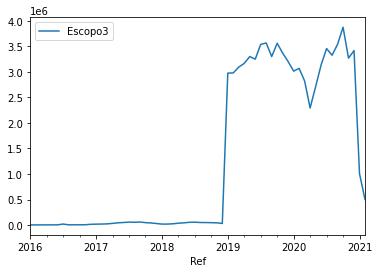

In [493]:

#dados escopo3
escopo3 = df.filter(['Ref','Escopo3'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano
for index, row in escopo3.iterrows():
    if row['Escopo3'] <= 0:
      mediaMes = escopo3['Escopo3'].groupby([escopo3.index.month]).mean()[index.month]
      mediaAno = escopo3['Escopo3'].groupby([escopo3.index.year]).mean()[index.year]
      if mediaMes == 0.0:         
         row['Escopo3'] = mediaAno
      elif mediaAno == 0.0:  
         row['Escopo3'] = mediaMes
      elif (mediaAno < (mediaMes * 1.2)):
         row['Escopo3'] = mediaAno
      else:
         row['Escopo3'] = mediaMes
escopo3.plot()

In [502]:
escopo3.tail(10)

,Escopo3,Primeira Diferenciação,Diferença Sazonal
Ref,,,
2020-05-01,2.708953e+06,4.160887e+05,-5.914589e+05
2020-06-01,3.135337e+06,4.263839e+05,-1.141550e+05
2020-07-01,3.457533e+06,3.221962e+05,-8.127446e+04
2020-08-01,3.325764e+06,-1.317692e+05,-2.404136e+05
2020-09-01,3.540271e+06,2.145074e+05,2.399228e+05
2020-10-01,3.874630e+06,3.343591e+05,3.138942e+05
2020-11-01,3.270238e+06,-6.043926e+05,-9.757008e+04
2020-12-01,3.417787e+06,1.475491e+05,2.161070e+05
2021-01-01,1.005105e+06,-2.412682e+06,-2.010063e+06


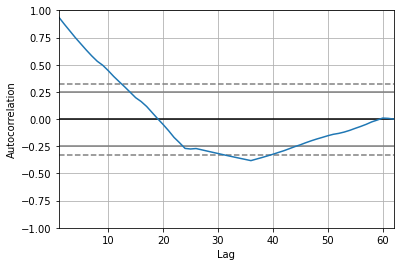

In [494]:
autocorrelation_plot(escopo3)
pyplot.show()

In [361]:
adfuller_test(escopo3['Escopo3'])

ADF Test Statistic : -1.8852883224128782
p-value : 0.3390132816331667
#Lags Used : 0
observações : 61
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


In [495]:
escopo3['Primeira Diferenciação'] = escopo3['Escopo3'] - escopo3['Escopo3'].shift(1)
escopo3['Diferença Sazonal']=escopo3['Escopo3']-escopo3['Escopo3'].shift(12)
adfuller_test(escopo3['Diferença Sazonal'].dropna())

ADF Test Statistic : -1.0124661793948972
p-value : 0.7486904371565832
#Lags Used : 0
observações : 49
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


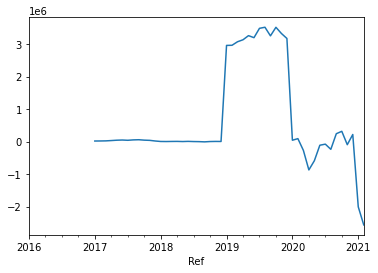

In [496]:
escopo3['Diferença Sazonal'].plot()

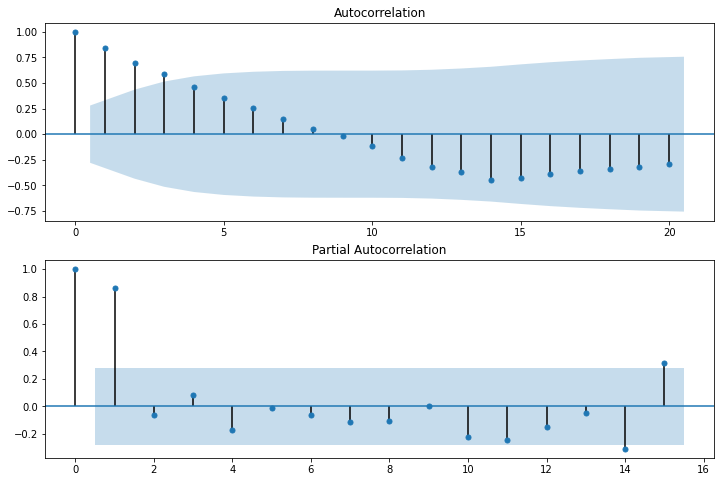

In [497]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo3['Diferença Sazonal'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo3['Diferença Sazonal'].iloc[13:],lags=15,ax=ax2)

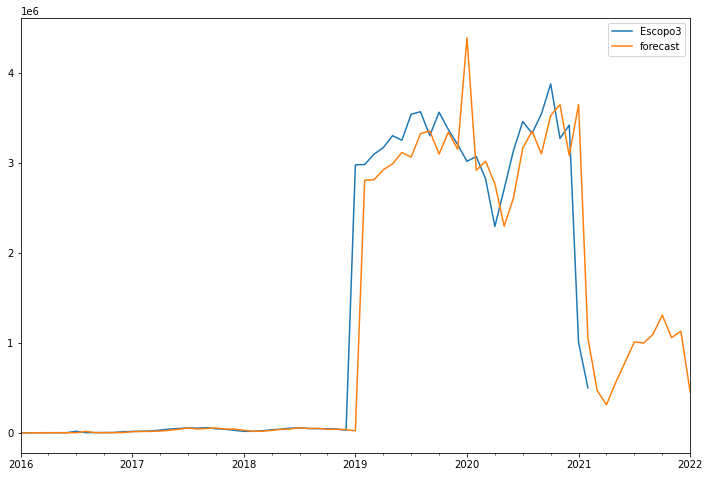

In [509]:
#essa é o modelo que foi aprendido para as previsões
model3=sm.tsa.statespace.SARIMAX(escopo3['Escopo3'],order=(1,0,0),seasonal_order=(1,1,1,12))
results3=model3.fit()

future_dates3=[escopo3.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest3_df=pd.DataFrame(index=future_dates3[1:],columns=escopo3.columns)
future_df3=pd.concat([escopo3,future_datest3_df])


future_df3['forecast'] = results3.predict(end=72)  

future_df3[['Escopo3', 'forecast']].plot(figsize=(12, 8))

In [505]:
future_df3.tail(12)

,Escopo3,Primeira Diferenciação,Diferença Sazonal,forecast
2021-02-01,502552.382617,-502552.382617,-2.566322e+06,1.059012e+06
2021-03-01,NaN,NaN,NaN,4.719394e+05
2021-04-01,NaN,NaN,NaN,3.135426e+05
2021-05-01,NaN,NaN,NaN,5.623513e+05
2021-06-01,NaN,NaN,NaN,7.874768e+05
2021-07-01,NaN,NaN,NaN,1.011864e+06
2021-08-01,NaN,NaN,NaN,9.994832e+05
2021-09-01,NaN,NaN,NaN,1.095286e+06
2021-10-01,NaN,NaN,NaN,1.308712e+06
2021-11-01,NaN,NaN,NaN,1.059038e+06
